In [17]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy.constants
from pynufft import NUFFT
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"
import sys
sys.path.append('./Modules')
import monostatic_reconstruct as mr

def set_font(fontsize=18, font="Times New Roman"):
    rc = {"font.size" : fontsize,
    "font.family" : font,
    "mathtext.fontset" : "stix"}
    plt.rcParams.update(rc)
set_font()

mm = 1E-3
C = scipy.constants.c

### Load data & antenna coordinates

In [18]:
d_antennas = .035        # distance between tx/rx antennas

mat = scipy.io.loadmat(r'..\..\Data\wall1_with_drywall_2022-11-13.mat')
notes = list(mat['notes'])
print('NOTES:')
for i in range(len(notes)):
        print(notes[i])
f = mat['f'][0,:]
Xa = np.flip(mat['X']*mm, axis=(0,1))   # flipping to recover right-handed coordinate systems
Ya = np.flip(mat['Y']*mm, axis=(0,1))       # flipping because origin of scan stage was at top left
Za = np.zeros_like(Xa)
measurements = np.flip(mat['measurements'], axis=(0,1))
z_offset = mat['z_offset'][0,0]*mm

### load background
mat = scipy.io.loadmat(r'..\..\Data\background_2022-11-11.mat')
bg = np.flip(mat['measurements'], axis=(0,1))

### subtract background from measurements
measurements = measurements - bg

NOTES:
second scan of wall1 with drywall.


### Remove probe phase

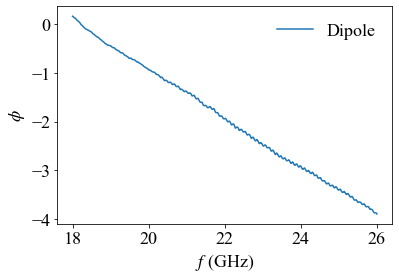

In [26]:
#### load experimentally measured probe phase
# mat = scipy.io.loadmat('../../Data/Horn_Calibration_221109/horn_phase.mat')
# phase_error_horn = mat['horn_phase'][0,:]
mat = scipy.io.loadmat('../../Data/Dipole_Calibration_221207/dipole_phase.mat')
phase_error_dipole = mat['dipole_phase'][0,:]

# measurements = measurements / np.exp(1j*2*phase_error_horn)[None,None,:]     # experimental horn data
measurements = measurements / np.exp(1j*2*phase_error_dipole)[None,None,:]     # experimental dipole data

plt.figure()
# plt.plot(f*1E-9, phase_error_horn, label='Horn')
plt.plot(f*1E-9, phase_error_dipole, label='Dipole')
plt.legend(frameon=False)
plt.xlabel('$f$ (GHz)')
plt.ylabel('$\phi$')
plt.show()

### Reconstruct

In [16]:
recon = mr.MonostaticReconstruction(f, Xa, Ya, z_offset)
# recon.setup((1, 1, .3), (5*mm, 5*mm, 5*mm), Lxa=0.8, Lya=0.8, fc=22E9, bw=8E9, delta_f_indx=4, scene_offsets=(-0.1,-0.2,z_offset), method='RMA-NUFFT')
# recon.setup((1, 1, .01), (5*mm, 5*mm, 5*mm), Lxa=0.8, Lya=0.8, fc=24.125E9, bw=0.25E9, delta_f_indx=1, aperture_center=(0, 0), scene_offsets=(-0.1,-0.2,z_offset+0.02), method='RMA-NUFFT', lp_filter=True, filter_radius=40, filter_x_offset=0, filter_y_offset=-55, quiet=False)
recon.setup((.6,.6, .01), (5*mm, 5*mm, 5*mm), Lxa=0.8, Lya=0.8, fc=24.125E9, bw=0.25E9, delta_f_indx=1, aperture_center=(0, 0), scene_offsets=(0,0,z_offset+0.02), method='RMA-NUFFT', lp_filter=True, filter_radius=40, filter_x_offset=0, filter_y_offset=-55, quiet=False)
# recon.setup((.3, .3, .01), (5*mm, 5*mm, 5*mm), Lxa=0.3, Lya=0.3, fc=24.125E9, bw=0.25E9, delta_f_indx=1, aperture_center=(-0.15, -0.15), scene_offsets=(-0.1,-0.2,z_offset+0.02), method='RMA-NUFFT', lp_filter=True, filter_radius=40, filter_x_offset=0, filter_y_offset=-55, quiet=False)

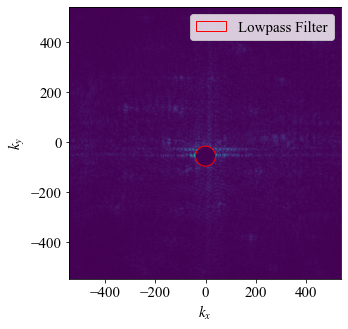

In [17]:
recon.reconstruct(measurements)

### Plot

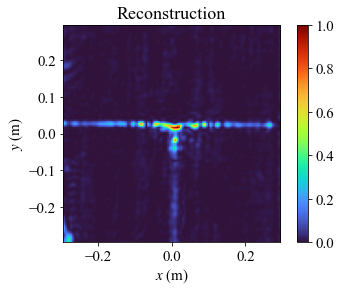

In [18]:
# recon.resample(.5)
recon.plot(plot_type='xy', scale='linear', cmap='turbo', colormin=0, colormax=1)
# recon.plot(plot_type='section', slice_axis='z', scale='linear', cmap='turbo', colormin=0, colormax=.5)
# recon.plot(plot_type='3D', scale='linear', cmap='Turbo', colormin=0, colormax=1, surface_count=100, opacity=0.05)

### Save data

In [9]:
scipy.io.savemat(r'C:\Users\User\Documents\Metacept\Projects\TWI\Experiment\Monostatic Experiments - Shared\Data\Image_Data\wall1_drywall_stage_angled.mat',
                 {'X': recon.volume.X,
                  'Y': recon.volume.Y,
                  'Z': recon.volume.Z,
                  'image': recon.image})